170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Train shape: (42000, 32, 32, 1) Test shape: (18000, 32, 32, 1)
PCA-picked latent dimension to retain 95% energy: K = 163


Model: "ae_single"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flat_input (InputLayer)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense (Dense)           │ (None, 163)            │       167,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (Dense)           │ (None, 1024)           │       167,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,011 (1.28 MB)

 Trainable params: 335,011 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
165/165 - 3s - 21ms/step - loss: 0.4325 - val_loss: 0.2745
Epoch 2/25
165/165 - 1s - 4ms/step - loss: 0.2298 - val_loss: 0.2024
Epoch 3/25
165/165 - 1s - 4ms/step - loss: 0.1784 - val_loss: 0.1649
Epoch 4/25
165/165 - 1s - 4ms/step - loss: 0.1507 - val_loss: 0.1445
Epoch 5/25
165/165 - 1s - 4ms/step - loss: 0.1326 - val_loss: 0.1290
Epoch 6/25
165/165 - 1s - 4ms/step - loss: 0.1195 - val_loss: 0.1178
Epoch 7/25
165/165 - 1s - 4ms/step - loss: 0.1097 - val_loss: 0.1087
Epoch 8/25
165/165 - 1s - 4ms/step - loss: 0.1021 - val_loss: 0.1016
Epoch 9/25
165/165 - 1s - 5ms/step - loss: 0.0959 - val_loss: 0.0960
Epoch 10/25
165/165 - 1s - 8ms/step - loss: 0.0909 - val_loss: 0.0914
Epoch 11/25
165/165 - 1s - 6ms/step - loss: 0.0868 - val_loss: 0.0877
Epoch 12/25
165/165 - 1s - 4ms/step - loss: 0.0833 - val_loss: 0.0847
Epoch 13/25
165/165 - 1s - 4ms/step - loss: 0.0804 - val_loss: 0.0822
Epoch 14/25
165/165 - 1s - 4ms/step - loss: 0.0780 - val_loss: 0.0799
Epoch 15/25
165/165 - 1s - 4

Model: "ae_conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)          │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 163)            │       333,987 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       335,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,002,660 (3.82 MB)

 Trainable params: 1,002,660 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
165/165 - 14s - 83ms/step - loss: 0.0382 - val_loss: 0.0163
Epoch 2/20
165/165 - 3s - 18ms/step - loss: 0.0136 - val_loss: 0.0110
Epoch 3/20
165/165 - 3s - 18ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 4/20
165/165 - 3s - 19ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 5/20
165/165 - 3s - 18ms/step - loss: 0.0078 - val_loss: 0.0107
Epoch 6/20
165/165 - 3s - 18ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/20
165/165 - 5s - 33ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 8/20
165/165 - 3s - 19ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/20
165/165 - 3s - 19ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/20
165/165 - 3s - 20ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 11/20
165/165 - 3s - 19ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 12/20
165/165 - 3s - 19ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 13/20
165/165 - 3s - 19ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 14/20
165/165 - 3s - 19ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 15/20
16

Model: "ae_3layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flat_input_3 (InputLayer)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 55)             │        56,375 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 55)             │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck3 (Dense)             │ (None, 53)             │         2,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 55)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 55)             │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │        57,344 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,817 (491.47 KB)

 Trainable params: 125,817 (491.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
165/165 - 5s - 33ms/step - loss: 0.8990 - val_loss: 0.7562
Epoch 2/30
165/165 - 1s - 4ms/step - loss: 0.7366 - val_loss: 0.7335
Epoch 3/30
165/165 - 1s - 4ms/step - loss: 0.7241 - val_loss: 0.7239
Epoch 4/30
165/165 - 1s - 4ms/step - loss: 0.7187 - val_loss: 0.7182
Epoch 5/30
165/165 - 1s - 4ms/step - loss: 0.6525 - val_loss: 0.6235
Epoch 6/30
165/165 - 1s - 4ms/step - loss: 0.6153 - val_loss: 0.6108
Epoch 7/30
165/165 - 1s - 4ms/step - loss: 0.6057 - val_loss: 0.6022
Epoch 8/30
165/165 - 1s - 4ms/step - loss: 0.5997 - val_loss: 0.6001
Epoch 9/30
165/165 - 1s - 4ms/step - loss: 0.5972 - val_loss: 0.5978
Epoch 10/30
165/165 - 1s - 4ms/step - loss: 0.5962 - val_loss: 0.5979
Epoch 11/30
165/165 - 1s - 4ms/step - loss: 0.5956 - val_loss: 0.6008
Epoch 12/30
165/165 - 1s - 5ms/step - loss: 0.5949 - val_loss: 0.5964
Epoch 13/30
165/165 - 1s - 6ms/step - loss: 0.5940 - val_loss: 0.5944
Epoch 14/30
165/165 - 1s - 5ms/step - loss: 0.5934 - val_loss: 0.5935
Epoch 15/30
165/165 - 1s - 4

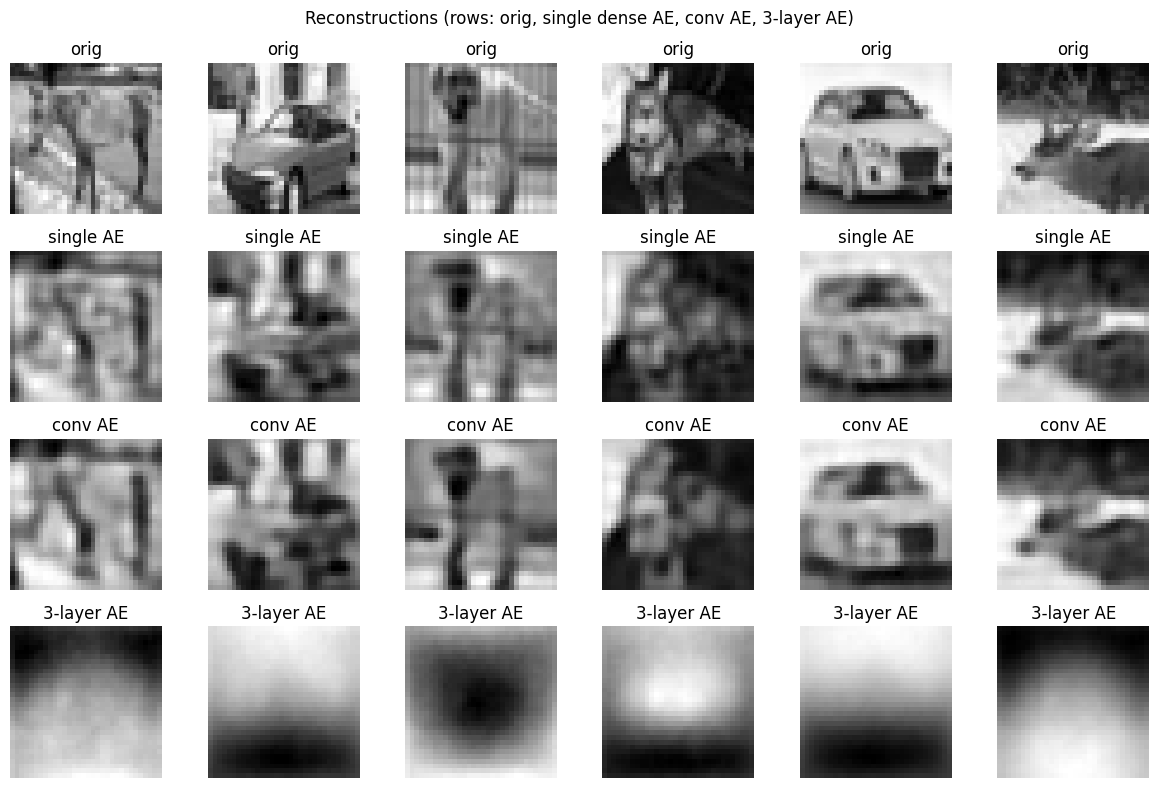

Results summary: {'PCA_95_K': 163, 'MSE_single_dense_AE': 0.0037526851519942284, 'MSE_conv_AE': 0.0037289306055754423, 'MSE_3layer_AE': 0.028116121888160706}
Models & histories saved to ./models


In [ ]:

import os
import math
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- try imports for TF/Keras ---
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    raise RuntimeError("TensorFlow (tensorflow) is required to run this script. "
                       "Please run on the course VM or install tensorflow. Error: " + str(e))

# ----------------------------
# Config / hyperparameters
# ----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

BATCH_SIZE = 256
EPOCHS_SINGLE = 25       # single-layer dense AE
EPOCHS_CONV = 20         # conv AE
EPOCHS_3LAYER = 30       # 3-layer dense AE

MODEL_SAVE_DIR = "./models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# ----------------------------
# Helper functions
# ----------------------------
def rgb2gray(images):
    # images in [0,1], shape (N,H,W,3)
    r, g, b = images[..., 0], images[..., 1], images[..., 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray[..., np.newaxis]

def recon_mse(orig, recon):
    # mean MSE per image averaged
    orig_flat = orig.reshape(orig.shape[0], -1)
    recon_flat = recon.reshape(recon.shape[0], -1)
    return np.mean(np.mean((orig_flat - recon_flat) ** 2, axis=1))

# ----------------------------
# Load CIFAR-10, convert to grayscale, split 70/30
# ----------------------------
(x_train0, y_train0), (x_test0, y_test0) = keras.datasets.cifar10.load_data()
x_all = np.vstack([x_train0, x_test0]).astype("float32") / 255.0
y_all = np.vstack([y_train0, y_test0]).squeeze()

x_gray = rgb2gray(x_all)  # shape (60000, 32, 32, 1)

X_train, X_test, y_train, y_test = train_test_split(
    x_gray, y_all, train_size=0.7, stratify=y_all, random_state=RANDOM_SEED
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

H, W = X_train.shape[1], X_train.shape[2]
input_dim = H * W

# Flattened standardized arrays for PCA & dense AEs
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize (zero mean, unit var) using training statistics
mean_train = X_train_flat.mean(axis=0)
std_train = X_train_flat.std(axis=0) + 1e-9
X_train_std = (X_train_flat - mean_train) / std_train
X_test_std = (X_test_flat - mean_train) / std_train

# ----------------------------
# PCA to find K for 95% explained variance
# ----------------------------
pca = PCA(n_components=0.95, svd_solver='full', random_state=RANDOM_SEED)
pca.fit(X_train_std)
K = pca.n_components_
print(f"PCA-picked latent dimension to retain 95% energy: K = {K}")

latent_dim = int(K)

# ----------------------------
# Model 1: Single hidden-layer dense AE (sigmoid encoder, linear decoder)
# ----------------------------
tf.keras.backend.clear_session()
inp = keras.Input(shape=(input_dim,), name="flat_input")
encoded = layers.Dense(latent_dim, activation='sigmoid', name="encoder_dense")(inp)
decoded = layers.Dense(input_dim, activation='linear', name="decoder_dense")(encoded)
ae_single = keras.Model(inp, decoded, name="ae_single")
ae_single.compile(optimizer='adam', loss='mse')
ae_single.summary()

# Train on standardized flattened data
history_single = ae_single.fit(
    X_train_std, X_train_std,
    epochs=EPOCHS_SINGLE, batch_size=BATCH_SIZE,
    validation_data=(X_test_std, X_test_std),
    verbose=2
)

# Reconstruct and invert standardization
recon_test_std = ae_single.predict(X_test_std)
recon_test_flat = recon_test_std * std_train + mean_train
recon_single = recon_test_flat.reshape(-1, H, W, 1)
mse_single = recon_mse(X_test, recon_single)
print("Single-layer AE test MSE:", mse_single)

# ----------------------------
# Model 2: Deep convolutional autoencoder with bottleneck of size K
# ----------------------------
tf.keras.backend.clear_session()
input_img = keras.Input(shape=(H, W, 1), name="img_input")
x_enc = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(input_img)  # 16x16x32
x_enc = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x_enc)      # 8x8x64
x_enc = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x_enc)     # 4x4x128
shape_before_flat = tf.keras.backend.int_shape(x_enc)[1:]  # tuple (4,4,128)
x_flat = layers.Flatten()(x_enc)
bottleneck = layers.Dense(latent_dim, name="bottleneck")(x_flat)  # linear bottleneck
# decoder
x_dec = layers.Dense(np.prod(shape_before_flat), activation='relu')(bottleneck)
x_dec = layers.Reshape(shape_before_flat)(x_dec)
x_dec = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x_dec)  # 8x8
x_dec = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x_dec)   # 16x16
x_dec = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x_dec)   # 32x32
decoded_img = layers.Conv2D(1, 3, padding='same', activation='linear')(x_dec)

ae_conv = keras.Model(input_img, decoded_img, name="ae_conv")
ae_conv.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
ae_conv.summary()

history_conv = ae_conv.fit(
    X_train, X_train,
    epochs=EPOCHS_CONV, batch_size=BATCH_SIZE,
    validation_data=(X_test, X_test),
    verbose=2
)

recon_conv = ae_conv.predict(X_test)
mse_conv = recon_mse(X_test, recon_conv)
print("Convolutional AE test MSE:", mse_conv)

# ----------------------------
# Model 3: 3-hidden-layer dense AE where total hidden nodes ≈ K and are split equally
# Interpretation: sum of encoder hidden nodes ≈ K and the last encoder layer acts as bottleneck.
# ----------------------------
tf.keras.backend.clear_session()
nodes_each = int(math.ceil(latent_dim / 3.0))
sizes = [nodes_each, nodes_each, max(1, latent_dim - 2 * nodes_each)]
print("3-layer encoder sizes (sum approx K):", sizes, "-> bottleneck size:", sizes[-1])

inp3 = keras.Input(shape=(input_dim,), name="flat_input_3")
h1 = layers.Dense(sizes[0], activation='sigmoid')(inp3)
h2 = layers.Dense(sizes[1], activation='sigmoid')(h1)
bott3 = layers.Dense(sizes[2], activation='sigmoid', name='bottleneck3')(h2)
# decoder (mirror)
d1 = layers.Dense(sizes[1], activation='sigmoid')(bott3)
d2 = layers.Dense(sizes[0], activation='sigmoid')(d1)
out3 = layers.Dense(input_dim, activation='linear')(d2)

ae_3layer = keras.Model(inp3, out3, name="ae_3layer")
ae_3layer.compile(optimizer='adam', loss='mse')
ae_3layer.summary()

history_3 = ae_3layer.fit(
    X_train_std, X_train_std,
    epochs=EPOCHS_3LAYER, batch_size=BATCH_SIZE,
    validation_data=(X_test_std, X_test_std),
    verbose=2
)

recon_3_std = ae_3layer.predict(X_test_std)
recon_3_flat = recon_3_std * std_train + mean_train
recon_3 = recon_3_flat.reshape(-1, H, W, 1)
mse_3layer = recon_mse(X_test, recon_3)
print("3-hidden-layer AE test MSE:", mse_3layer)

# ----------------------------
# Visualize a few reconstructions
# ----------------------------
n_show = 6
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, n_show, figsize=(n_show * 2, 8))
for i in range(n_show):
    axs[0, i].imshow(X_test[i].squeeze(), cmap='gray')
    axs[0, i].axis('off'); axs[0, i].set_title("orig")
    axs[1, i].imshow(recon_single[i].squeeze(), cmap='gray')
    axs[1, i].axis('off'); axs[1, i].set_title("single AE")
    axs[2, i].imshow(recon_conv[i].squeeze(), cmap='gray')
    axs[2, i].axis('off'); axs[2, i].set_title("conv AE")
    axs[3, i].imshow(recon_3[i].squeeze(), cmap='gray')
    axs[3, i].axis('off'); axs[3, i].set_title("3-layer AE")
plt.suptitle("Reconstructions (rows: orig, single dense AE, conv AE, 3-layer AE)")
plt.tight_layout()
plt.show()

# ----------------------------
# Results summary and save models
# ----------------------------
results = {
    "PCA_95_K": latent_dim,
    "MSE_single_dense_AE": float(mse_single),
    "MSE_conv_AE": float(mse_conv),
    "MSE_3layer_AE": float(mse_3layer)
}
print("Results summary:", results)

# Save models to MODEL_SAVE_DIR
ae_single.save(os.path.join(MODEL_SAVE_DIR, "ae_single.h5"))
ae_conv.save(os.path.join(MODEL_SAVE_DIR, "ae_conv.h5"))
ae_3layer.save(os.path.join(MODEL_SAVE_DIR, "ae_3layer.h5"))

# Also save training histories (optional)
import json
def history_to_dict(h):
    return {k: [float(v) for v in vals] for k, vals in h.history.items()}

with open(os.path.join(MODEL_SAVE_DIR, "hist_single.json"), "w") as f:
    json.dump(history_to_dict(history_single), f)
with open(os.path.join(MODEL_SAVE_DIR, "hist_conv.json"), "w") as f:
    json.dump(history_to_dict(history_conv), f)
with open(os.path.join(MODEL_SAVE_DIR, "hist_3layer.json"), "w") as f:
    json.dump(history_to_dict(history_3), f)

print(f"Models & histories saved to {MODEL_SAVE_DIR}")
